<a href="https://colab.research.google.com/github/SuhasiniTatipalli/House-Prices-Prediction/blob/main/Neural_Network_Kaggle_Exercise_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(display='diagram')
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error, \
r2_score

from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics



In [ ]:
# Learning history plotting function
def plot_history(history):
  """Takes a keras model learning history and plots each metric"""
  
  metrics = history.history.keys()
  
  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

In [ ]:
# Function to evaluate a regression model
def evaluate_regression(y_true, y_pred, name='model'):
  """Pass true and predicted targets and optionally give the model a name.
  Returns a dataframe with metrics"""
  
  scores = pd.DataFrame(index=['R2','MAE','RMSE'],
                        columns=[name])
  scores.loc['R2', name] = r2_score(y_true, y_pred)
  scores.loc['MAE', name] = mean_absolute_error(y_true, y_pred)
  scores.loc['RMSE', name] = np.sqrt(mean_squared_error(y_true, y_pred))
  return scores


In [ ]:
# Load Data
df_h = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep learning/Kaggle-Neural Network Kaggle Exercise (Core)/train.csv')
df_h.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# check missing values and duplicates
print('missing values', df_h.info())
print('\nduplicated rows', df_h.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
#check for nulls
df_h.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [ ]:
df_nulls = df_h.isnull().sum().sort_values(ascending=False)
df_nulls.head(25)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
Functional         0
Fireplaces         0
KitchenQual        0
KitchenAbvGr       0
BedroomAbvGr       0
dtype: int64

In [ ]:
df_ratio_nulls = (df_nulls / len(df_h)).reset_index()
df_ratio_nulls.columns = ['Feature', 'ratio_nulls']
df_ratio_nulls[df_ratio_nulls['ratio_nulls'] >0]

,Feature,ratio_nulls
0,PoolQC,0.995205
1,MiscFeature,0.963014
2,Alley,0.937671
3,Fence,0.807534
4,FireplaceQu,0.472603
5,LotFrontage,0.177397
6,GarageYrBlt,0.055479
7,GarageCond,0.055479
8,GarageType,0.055479
9,GarageFinish,0.055479


In [ ]:
#Delete the PoolQC, MiscFeature, Alley, Fence, FireplaceQu  columns because they contain 50% or more nulls values.
df_h = df_h.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'])
df_h.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [ ]:
df_h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [ ]:
df_h.shape

(1460, 76)

In [ ]:
df_h['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [ ]:
#Use random_state = 42 for your train_test_split
X = df_h.drop(columns = ['SalePrice'])
y = df_h['SalePrice']

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1023,1024,120,RL,43.0,3182,Pave,Reg,Lvl,AllPub,Inside,...,20,0,0,0,0,0,5,2008,WD,Normal
810,811,20,RL,78.0,10140,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,648,0,1,2006,WD,Normal
1384,1385,50,RL,60.0,9060,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,10,2009,WD,Normal
626,627,20,RL,NaN,12342,Pave,IR1,Lvl,AllPub,Inside,...,0,36,0,0,0,600,8,2007,WD,Normal
813,814,20,RL,75.0,9750,Pave,Reg,Lvl,AllPub,Inside,...,0,275,0,0,0,500,4,2007,COD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,1096,20,RL,78.0,9317,Pave,IR1,Lvl,AllPub,Inside,...,22,0,0,0,0,0,3,2007,WD,Normal
1130,1131,50,RL,65.0,7804,Pave,Reg,Lvl,AllPub,Inside,...,44,0,0,0,0,0,12,2009,WD,Normal
1294,1295,20,RL,60.0,8172,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,4,2006,WD,Normal
860,861,50,RL,55.0,7642,Pave,Reg,Lvl,AllPub,Corner,...,240,0,0,0,0,0,6,2007,WD,Normal


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1095 entries, 1023 to 1126
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1095 non-null   int64  
 1   MSSubClass     1095 non-null   int64  
 2   MSZoning       1095 non-null   object 
 3   LotFrontage    895 non-null    float64
 4   LotArea        1095 non-null   int64  
 5   Street         1095 non-null   object 
 6   LotShape       1095 non-null   object 
 7   LandContour    1095 non-null   object 
 8   Utilities      1095 non-null   object 
 9   LotConfig      1095 non-null   object 
 10  LandSlope      1095 non-null   object 
 11  Neighborhood   1095 non-null   object 
 12  Condition1     1095 non-null   object 
 13  Condition2     1095 non-null   object 
 14  BldgType       1095 non-null   object 
 15  HouseStyle     1095 non-null   object 
 16  OverallQual    1095 non-null   int64  
 17  OverallCond    1095 non-null   int64  
 18  YearB

In [ ]:
#instantiate the StandardScaler, OneHotEncoder Imputers
# Scaler
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')

mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')

In [ ]:
#a) Create column selectors for the numeric and categorical columns
cat_selector = make_column_selector(dtype_include = 'object')
num_selector = make_column_selector(dtype_include = 'number')

In [ ]:
# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer,scaler)
# Categorical pipeline
categorical_pipe = make_pipeline(freq_imputer,ohe)

In [ ]:
# Tuples for Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)

In [ ]:
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple, remainder = 'passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa9099bd690>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa9099bd4d0>)])

In [ ]:
# process the data
preprocessor.fit(X_train, y_train)
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

X_train_proc.shape

(1095, 267)

In [ ]:
X_train_proc.shape[1]

267

#Model 1

In [ ]:
# create and compile the model
input_dim = X_train_proc.shape[1]

model = keras.Sequential()

model.add(Dense(261, input_dim=input_dim, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 261)               69948     
                                                                 
 dense_1 (Dense)             (None, 100)               26200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 96,249
Trainable params: 96,249
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compile model with additional metrics

model.compile(loss='mse', optimizer='adam',
               metrics=[metrics.MeanAbsoluteError(),
                        metrics.RootMeanSquaredError()])


In [ ]:
history = model.fit(X_train_proc, y_train,
                        validation_data = (X_test_proc, y_test),
                        epochs=100,
                        verbose=0)

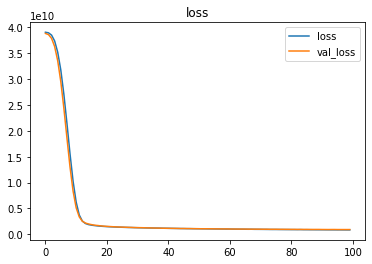

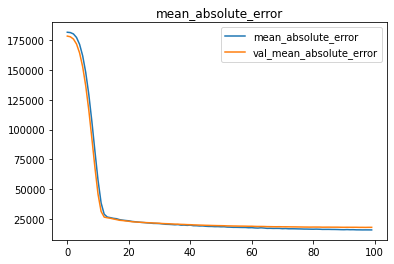

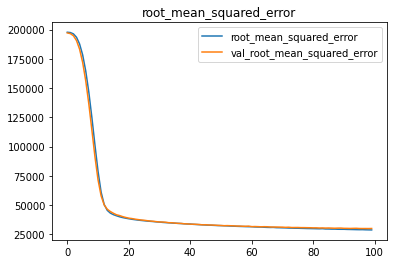

In [ ]:
# plot learning

plot_history(history)

In [ ]:
# evaluate model

y_pred1 = model.predict(X_test_proc)

print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred1))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred1)}')
print(f'final R2: {r2_score(y_test, y_pred1)}')

12/12 [==============================] - 0s 2ms/step
final RMSE: 29977.354701947836
final MAE: 18022.43227739726
final R2: 0.8717198929822653


This model has a nice hockey-stick-shaped learning curve and the final training and testing scores are very similar. It does not seem to suffer from overfitting or underfitting.
The R2 score shows that this model is explaining about 87% of the variance in the target, the mean absolute error shows that this model tends to make an error of about 181K saleprice, and since the root mean squared error is significantly higher than the mean absolute error, this shows us that it has made some larger errors on some samples.

Now work on Test data to submit to Kaggle

In [ ]:
df_test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep learning/Kaggle-Neural Network Kaggle Exercise (Core)/test_h.csv',index_col = 0)
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
df_test.reset_index(inplace=True)
df_test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [ ]:
#Check for duplicates
df_test.duplicated().sum()

0

In [ ]:
test_features = df_test[X_train.columns]
test_features.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,120,0,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,...,36,0,0,0,0,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,...,34,0,0,0,0,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,...,36,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,...,82,0,0,144,0,0,1,2010,WD,Normal


In [ ]:
test_features_proc = preprocessor.transform(test_features)

In [ ]:
#check for nulls

df_nulls = test_features.isna().sum().sort_values(ascending=False)
df_nulls.head(30)

LotFrontage     227
GarageYrBlt      78
GarageFinish     78
GarageQual       78
GarageCond       78
GarageType       76
BsmtCond         45
BsmtExposure     44
BsmtQual         44
BsmtFinType1     42
BsmtFinType2     42
MasVnrType       16
MasVnrArea       15
MSZoning          4
Utilities         2
Functional        2
BsmtHalfBath      2
BsmtFullBath      2
Exterior2nd       1
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
KitchenQual       1
TotalBsmtSF       1
Exterior1st       1
GarageArea        1
SaleType          1
GarageCars        1
MoSold            0
FullBath          0
dtype: int64

Dropping Rows
with missing values in the above columns. We will just drop since they represent a very small percentage of our data.

In [ ]:
#test_features.dropna(subset=['LotFrontage'], inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
#test_features.dropna(subset=['GarageYrBlt','GarageFinish'], inplace=True)

In [ ]:
#test_features.dropna(subset=['BsmtCond','BsmtQual','BsmtExposure','BsmtFinType1','BsmtFinType2','MasVnrType','MasVnrArea',
#'MSZoning','BsmtFullBath','BsmtHalfBath','Functional','BsmtFinSF1','KitchenQual','TotalBsmtSF','BsmtUnfSF','Utilities',
#'SaleType','BsmtFinSF2'], inplace=True)

In [ ]:
test_features.info()

In [ ]:
preds = model.predict(test_features_proc)


46/46 [==============================] - 0s 2ms/step


In [ ]:
preds = preds.reshape(-1)


In [ ]:
submission=pd.DataFrame()

In [ ]:
submission['Id']=test_features.Id
submission['SalePrice']=preds
submission.head()

,Id,SalePrice
0,1461,109780.570312
1,1462,132013.218750
2,1463,177089.750000
3,1464,196956.078125
4,1465,191507.359375


In [ ]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         1459 non-null   int64  
 1   SalePrice  1459 non-null   float32
dtypes: float32(1), int64(1)
memory usage: 17.2 KB


In [ ]:
submission.to_csv('submission_2.csv')